In [241]:
import pandas as pd
import csv
import os
import re

# plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.font_manager as font_manager

sns.set_theme()

## Load data

In [252]:
# load txt files, each containing pseudoperplexity

perplexity = {}
directory = '../../0_results/mlm'
for dataset in os.listdir(directory):
    perplexity[dataset]={}
    for test_type in os.listdir(os.path.join(directory, dataset)):
        perplexity[dataset][test_type]={}
        for result_txt in os.listdir(os.path.join(directory, dataset, test_type)):
            if result_txt.endswith(".txt"):
                with open(os.path.join(directory, dataset, test_type, result_txt), 'r') as file:
                    perplexity[dataset][test_type][os.path.splitext(result_txt)[0]] = float(file.read().replace('\n', ''))

# Results on Random Test Set

In [47]:
def results_on_rand(DATASET):
    plot_df = pd.DataFrame.from_dict(perplexity[DATASET]["test-on-rand"], orient="index")
    
    plot_df.sort_index(inplace=True)
    plot_df.rename(columns={0:'pseudo-perplexity'}, inplace=True)
    plot_df.index.name="Model"
    
    cm = sns.color_palette('Greens_r', as_cmap=True)
    display(plot_df.style.background_gradient(cmap=cm, axis = 0 ).set_table_attributes('style="font-family: CMU Serif; font-size:16px"').format('{0:,.2f}'))

In [129]:
results_on_rand("gab")

,pseudo-perplexity
Model,
bert-01_1m-rand_10k,11.99
bert-02_1m-rand_10k,11.77
bert-03_1m-rand_10k,11.74
bert-04_1m-rand_10k,11.64
bert-05_1m-rand_10k,11.49
bert-06_1m-rand_10k,11.51
bert-07_1m-rand_10k,11.50
bert-08_1m-rand_10k,11.61
bert-09_1m-rand_10k,11.61


# Results on Monthly Test Sets: Absolute Values & Relative to Random Control Baseline

In [145]:
# helper function for diverging color palette
def background_gradient(s, m, M, cmap='BuPu', low=0, high=0):
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

def results_on_month(DATASET, BASELINE_MODEL="",
                     YEAR_FILTER = ["2017", "2018", "2019", "2020"],
                     MONTH_FILTER = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]):    
    
    result_dict = perplexity[DATASET]["test-on-month"]
    
    perpl_series = {}
    for model in sorted(pd.unique(pd.Series(result_dict.keys()).apply(lambda x: re.search(r'(.*?)-test(.*?)', x).group(1)))):
        if "bert-rand" not in model and "bert-base" not in model \
        and any(year in model for year in YEAR_FILTER) and any("_"+month in model for month in MONTH_FILTER):
            perpl_series[model] = {}
            for key in sorted(result_dict):
                if model in key and any("_"+year in re.search(r'(.*?)-test(.*)', key).group(2) for year in YEAR_FILTER) \
                and any("_"+month in re.search(r'(.*?)-test(.*)', key).group(2) for month in MONTH_FILTER):
                    perpl_series[model]["test" + re.search(r'(.*?)-test(.*)', key).group(2)] = result_dict[key]
    
    
    plot_df = pd.DataFrame.from_dict(perpl_series).reset_index().rename(columns={'index':'model'})
    plot_df.set_index('model', inplace=True)
    plot_df.index.name="Adapt."
    plot_df = plot_df.T
    
    cm = sns.color_palette('Greens_r', as_cmap=True)
    
    if BASELINE_MODEL!="":
        baseline_series = {}
        for key in sorted(result_dict):
                if BASELINE_MODEL in key:
                    baseline_series["test" + re.search(r'(.*?)-test(.*)', key).group(2)] = result_dict[key]
        for column in plot_df.columns: # divide by baseline model performance
            plot_df[column] = plot_df[column].divide(baseline_series[column])-1
        
        # format column names
        plot_df.columns = pd.Series(plot_df.columns).apply(lambda x: re.search("test_(.*?)_(.*?)_(.*)", x).group(1)[-2:] + "-" + re.search("test_(.*?)_(.*?)_(.*)", x).group(2))
        
        # format row names --> index
        for elem in plot_df.index:
            plot_df.rename(index={elem: re.search("bert-(.*?)_(.*?)_(.*)", elem).group(1)[-2:] + "-" + re.search("bert-(.*?)_(.*?)_(.*)", elem).group(2)}, inplace=True)
        
        # multiply by 100 to get pct values
        plot_df = plot_df.multiply(100)
        
        # define diverging color palette
        cm = sns.diverging_palette(150, 10, as_cmap=True)
        even_range = np.max([np.abs(plot_df.values.min()), np.abs(plot_df.values.max())])

        
        display(plot_df.style.apply(background_gradient,cmap=cm, m=-even_range, M=even_range)\
                .set_table_attributes('style="font-family: CMU Serif; font-size:26px"').set_precision(2))
    
    else:
        display(plot_df.style.background_gradient(cmap=cm, axis = 0 ).format('{0:,.2f}'))
        
    return plot_df

In [149]:
df = results_on_month("gab", BASELINE_MODEL="bert-rand_1m")#, MONTH_FILTER = ["04", "08", "12"])
np.diag(df).mean()

Adapt.,18-01,18-02,18-03,18-04,18-05,18-06,18-07,18-08,18-09,18-10
18-01,-5.76,2.48,5.30,6.22,8.90,15.89,9.20,17.98,15.95,17.57
18-02,-0.21,-5.53,1.15,4.53,7.01,15.39,8.71,16.07,15.58,16.85
18-03,2.40,0.41,-6.52,1.18,5.28,13.49,6.88,14.22,14.28,14.76
18-04,3.17,2.89,-0.32,-7.17,1.61,10.83,5.99,13.15,12.51,13.85
18-05,3.82,3.46,1.57,0.04,-5.22,8.35,3.74,11.97,11.39,12.58
18-06,5.23,6.23,4.50,3.59,1.62,-0.85,0.66,11.02,10.80,11.61
18-07,6.44,6.88,6.24,5.95,5.08,8.04,-5.73,8.44,8.20,9.56
18-08,8.00,8.19,7.16,7.23,6.55,11.59,1.81,-2.34,0.96,5.43
18-09,9.54,9.12,7.93,8.94,9.22,14.23,4.21,5.33,-10.20,0.23
18-10,9.41,10.13,9.48,9.62,9.64,15.06,5.65,8.57,-1.29,-7.45


-5.676297445352968

In [133]:
df = results_on_month("reddit", BASELINE_MODEL="bert-rand_1m", MONTH_FILTER = ["04", "08", "12"])

Adapt.,17-04,17-08,17-12,18-04,18-08,18-12,19-04,19-08,19-12
17-04,-3.12,0.20,2.30,2.45,3.70,4.19,4.47,5.84,5.09
17-08,1.06,-2.97,1.66,2.16,2.43,3.26,3.61,4.38,4.13
17-12,1.20,0.55,-2.44,0.86,1.73,2.16,1.98,2.55,2.08
18-04,1.08,0.55,1.14,-1.89,1.23,1.82,1.91,1.84,2.08
18-08,1.98,0.44,0.53,0.44,-1.65,0.67,0.89,1.00,1.09
18-12,2.04,1.72,1.18,0.93,0.55,-1.35,0.61,1.13,0.80
19-04,2.33,1.50,1.57,0.98,0.92,0.45,-1.98,0.82,0.38
19-08,3.14,1.80,1.98,1.38,1.99,1.31,1.22,-2.28,0.67
19-12,3.18,2.57,1.60,2.11,1.76,1.18,0.67,0.35,-1.99


# Cumu Model Results
Reddit only

In [258]:
# load three series of pseudo-perplexities:
plot_series = {}


# 1. model adapted to first month (2017_03_1m)
plot_series["first month"] = {}

for key in sorted(perplexity["reddit"]["test-on-month"]):
    if "bert-2017_03_1m" in key:
        plot_series["first month"][re.search(r"(.*?)-test_20(.*)_10k",key).group(2).replace("_", "/")] = perplexity["reddit"]["test-on-month"][key]
     
    
# 2. models adapted to current month
plot_series["test month"] = {}

for key in sorted(perplexity["reddit"]["test-on-month"]):
    if re.search(r"bert-(.*?)_1m-(.*)", key).group(1) == re.search(r"(.*?)test_(.*?)_10k(.*)", key).group(2):
        plot_series["test month"][re.search(r"(.*?)-test_20(.*)_10k",key).group(2).replace("_", "/")] = perplexity["reddit"]["test-on-month"][key]
    

# 3. cumulative models adapted to months up to and including current month
plot_series["cumu. month"] = {}

for key in sorted(perplexity["reddit"]["cumu-test"]):
    if re.search(r"bert-cumu_(.*?)_1m-(.*)", key).group(1) == re.search(r"(.*?)test_(.*?)_10k(.*)", key).group(2):
        plot_series["cumu. month"][re.search(r"(.*?)-test_20(.*)_10k",key).group(2).replace("_", "/")] = perplexity["reddit"]["cumu-test"][key]

    
# write to df
plot_df = pd.DataFrame.from_dict(plot_series)

# load baseline series for normalisation
baseline_series = {}

for key in sorted(perplexity["reddit"]["test-on-month"]):
        if "bert-rand_1m" in key:
            baseline_series[re.search(r"(.*?)-test_20(.*)_10k",key).group(2).replace("_", "/")] = perplexity["reddit"]["test-on-month"][key]

# divide each column in df by baseline series
for column in plot_df.columns:
    plot_df[column] = plot_df[column].divide(pd.Series(baseline_series), axis=0)-1

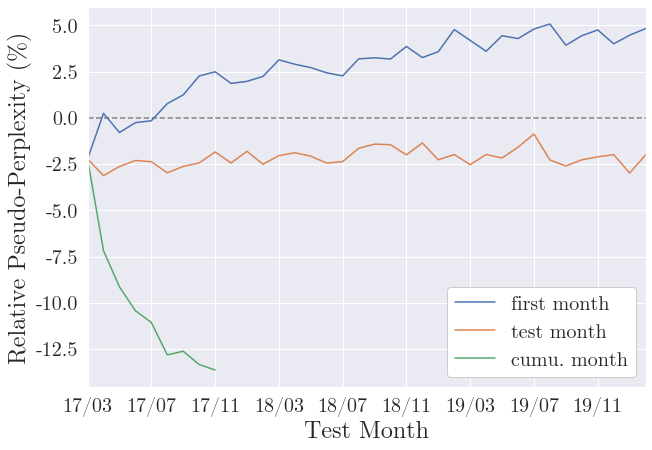

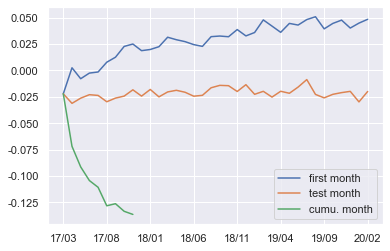

In [260]:
# create plot from plot_df

fig, ax = plt.subplots(figsize = (10,7))

ax.plot(plot_df)
loc = plticker.MultipleLocator(base=4.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)

# set labels for x and y axis
plt.xlabel('Test Month', fontsize=24, fontname="CMU Serif")
plt.ylabel('Relative Pseudo-Perplexity (%)', fontsize=24, fontname="CMU Serif")

# set the font for axis tick labels to be CMU Serif
matplotlib.rcParams['axes.unicode_minus'] = False
for tick in ax.get_xticklabels():
    tick.set_fontname("CMU Serif")
for tick in ax.get_yticklabels():
    tick.set_fontname("CMU Serif")

# set tick font size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# change y axis to percent, without the % symbol    
ax.yaxis.set_major_formatter(plticker.PercentFormatter(1.0, symbol=""))

# add horizontal line at 0
plt.hlines(0, xmin="17/03", xmax="20/02", colors="grey", linestyles="dashed")

# cut off x axis at first and last month
ax.set_xlim(left="17/03", right = "20/02")

# create legend
font = font_manager.FontProperties(family='CMU Serif',style='normal', size=20)
lines, labels = plot_df.plot().get_legend_handles_labels()
ax.legend(lines, labels, loc='best', facecolor='white', framealpha=1, fontsize=20, prop = font)

plt.show()